In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display


In [27]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        # Encoder
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, latent_dim)

        # Decoder
        self.fc4 = nn.Linear(latent_dim, 128)
        self.fc5 = nn.Linear(128, 256)
        self.fc6 = nn.Linear(256, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        # Decoder
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.sigmoid(self.fc6(x))
        return x


In [28]:
def get_mnist_loaders(batch_size=128):
    transform = transforms.ToTensor()
    train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    return DataLoader(train, batch_size=batch_size, shuffle=True), DataLoader(test, batch_size=1000)

train_loader, test_loader = get_mnist_loaders()


In [29]:
def train(model, train_loader, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in train_loader:
            images = images.view(images.size(0), -1).to(device)
            outputs = model(images)
            loss = criterion(outputs, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


In [33]:
model = Autoencoder(latent_dim=128)
train(model, train_loader, epochs=15)


Epoch 1, Loss: 0.0499
Epoch 2, Loss: 0.0236
Epoch 3, Loss: 0.0178
Epoch 4, Loss: 0.0146
Epoch 5, Loss: 0.0124
Epoch 6, Loss: 0.0108
Epoch 7, Loss: 0.0098
Epoch 8, Loss: 0.0090
Epoch 9, Loss: 0.0084
Epoch 10, Loss: 0.0079
Epoch 11, Loss: 0.0075
Epoch 12, Loss: 0.0071
Epoch 13, Loss: 0.0068
Epoch 14, Loss: 0.0065
Epoch 15, Loss: 0.0062


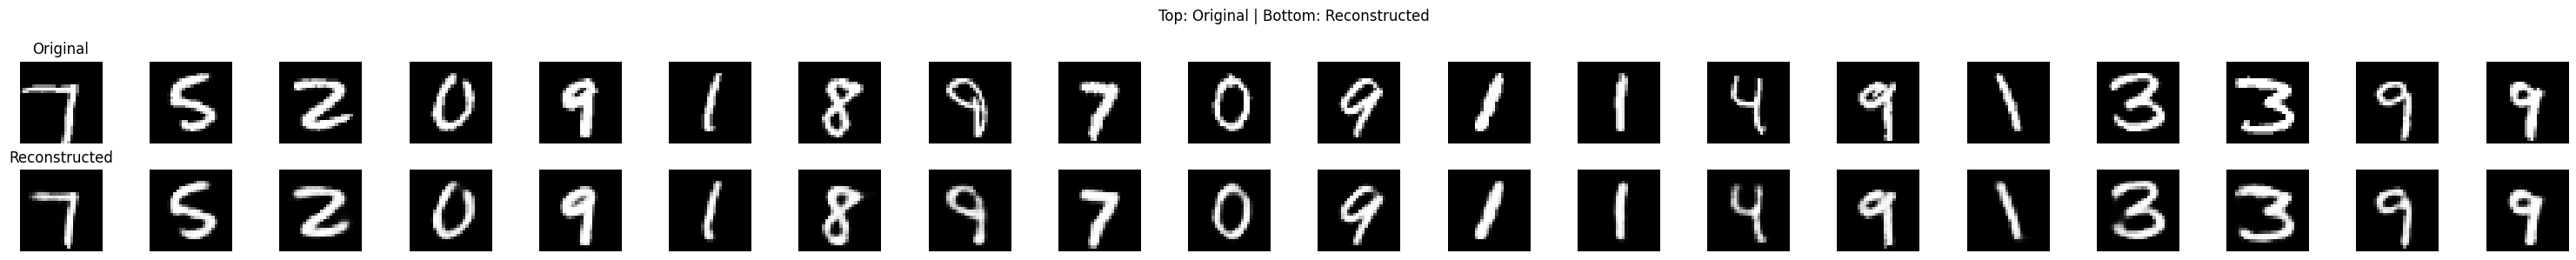

In [35]:
def show_reconstructions(model, test_loader, device, num_samples=20):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(test_loader))
        images_flat = images.view(images.size(0), -1).to(device)
        outputs = model(images_flat)

        images = images.view(-1, 28, 28).cpu().numpy()
        outputs = outputs.view(-1, 28, 28).cpu().numpy()

        idxs = np.random.choice(len(images), num_samples, replace=False)

        plt.figure(figsize=(num_samples * 1.5, 3))
        for i, idx in enumerate(idxs):
            # Original
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(images[idx], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title("Original")

            # Reconstructed
            plt.subplot(2, num_samples, i + 1 + num_samples)
            plt.imshow(outputs[idx], cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title("Reconstructed")

        plt.suptitle("Top: Original | Bottom: Reconstructed")
        plt.tight_layout()
        display(plt.gcf())
        plt.close()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
show_reconstructions(model, test_loader, device)
